<a href="https://colab.research.google.com/github/SushantVij/NLP-CV-IOT-UCS657-/blob/main/RISE_11_RNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from joblib import Parallel, delayed
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [3]:
# Load data
df = pd.read_csv('/content/train.csv')

# Preprocess text
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
def preprocess_text_parallel(text, stop_words):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

def preprocess_parallel(column, stop_words):
    return Parallel(n_jobs=-1)(delayed(preprocess_text_parallel)(text, stop_words) for text in column)

# Define stop words
stop_words = set(stopwords.words('english'))

df['text_cleaned'] = preprocess_parallel(df['text'], stop_words)



In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['text_cleaned'], df['Y'], test_size=0.2, random_state=42)

# Vectorize text
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


In [6]:

# Tokenize and pad sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)


In [7]:
# Build the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
    model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(Dense(3, activation='softmax'))
    return model

In [8]:
# Compile the model
model = create_lstm_model()
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/5
823/823 [==============================] - 462s 550ms/step - loss: 0.7185 - accuracy: 0.6948 - val_loss: 0.5058 - val_accuracy: 0.8200
Epoch 2/5
823/823 [==============================] - 441s 536ms/step - loss: 0.4110 - accuracy: 0.8704 - val_loss: 0.4562 - val_accuracy: 0.8433
Epoch 3/5
823/823 [==============================] - 445s 541ms/step - loss: 0.3221 - accuracy: 0.9025 - val_loss: 0.4891 - val_accuracy: 0.8346
Epoch 4/5
823/823 [==============================] - 440s 535ms/step - loss: 0.2642 - accuracy: 0.9201 - val_loss: 0.5470 - val_accuracy: 0.8301
Epoch 5/5
823/823 [==============================] - 444s 539ms/step - loss: 0.2157 - accuracy: 0.9352 - val_loss: 0.6390 - val_accuracy: 0.8285


In [9]:
# Testing
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)


258/258 [==============================] - 23s 88ms/step


In [10]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

Accuracy: 0.8494715101445753

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      3123
           1       0.83      0.80      0.82      1511
           2       0.86      0.89      0.87      3597

    accuracy                           0.85      8231
   macro avg       0.85      0.84      0.84      8231
weighted avg       0.85      0.85      0.85      8231



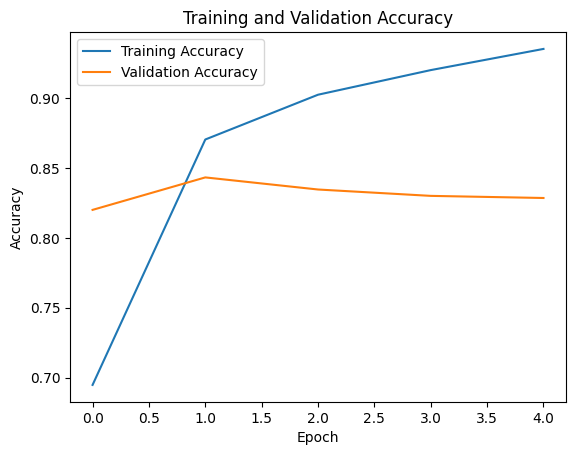

In [11]:
# Additional metrics and analysis
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()